# 1 - Bigramas e trigramas

Nosso objetivo é usar redes neurais para gerar algo que se parece com português. Mais especificamente, algo que se pareça com um português específico --- aquele usado por Machado de Assis.

O código desse notebook é adaptado do repositório `nn-zero-to-hero`, de Andrej Karpathy. Os notebooks correspondentes (em inglês) podem ser encontradas na seguinte URL: https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/.

-------------------------------

## 1.1 Explorando os dados

Em primeiro lugar, vamos baixar todos os livros do Machado de Assis no diretório `data/raw`.

In [1]:
# import nltk
# nltk.download('machado', download_dir='../data/gpt/raw')

# !mv ../data/gpt/raw/corpora/machado.zip ../data/gpt/raw/machado.zip
# !unzip ../data/gpt/raw/machado.zip -d ../data/gpt/raw
# !rm -R ../data/gpt/raw/corpora
# !rm ../data/gpt/raw/machado.zip

### 1.1.1 Lendo um livro do Machado de Assis

In [2]:
import pathlib

In [3]:
with open('../data/gpt/raw/machado/contos/macn001.txt', 'r', encoding='iso-8859-1') as f:
    lines = f.read().splitlines()
lines[0:10]

['Conto, Contos Fluminenses, 1870',
 '',
 'Contos Fluminenses',
 '',
 'Texto-fonte:',
 '',
 'Obra Completa, Machado de Assis, vol. II,',
 '',
 'Rio de Janeiro: Nova Aguilar, 1994.',
 '']

In [4]:
lines[200:220]

['Mata-cavalos. Vigorava, portanto, o nome tradicional da rua, que não queria',
 'dizer coisa nenhuma de jeito.',
 '',
 'A casa que tinha o número indicado no',
 'anúncio era de bonita aparência e indicava certa abastança nos haveres de quem',
 'lá morasse. Antes mesmo que Mendonça batesse palmas no corredor, já Miss',
 'Dollar, reconhecendo os pátrios lares, começava a pular de contente e a',
 'soltar uns sons alegres e guturais que, se houvesse entre os cães literatura,',
 'deviam ser um hino de ação de graças.',
 '',
 'Veio um moleque saber quem estava;',
 'Mendonça disse que vinha restituir a galga fugitiva. Expansão do rosto do',
 'moleque, que correu a anunciar a boa nova. Miss Dollar, aproveitando uma',
 'fresta, precipitou-se pelas escadas acima. Dispunha-se Mendonça a descer, pois',
 'estava cumprida a sua tarefa, quando o moleque voltou dizendo-lhe que subisse e',
 'entrasse para a sala.',
 '',
 'Na sala não havia ninguém. Algumas',
 'pessoas, que têm salas elegantemente disp

Quantas linhas esse livro tem?

In [5]:
len(lines)

9704

### 1.1.2 Lendo toda a obra de Machado de Assis

In [6]:
text = []
for text_path in sorted(pathlib.Path("../data/gpt/raw/machado/").rglob("*.txt")):
    with open(text_path, 'r', encoding='iso-8859-1') as f:
        lines = f.read().splitlines()
    text += lines

Ao todo, quantas linhas Machado de Assis escreveu?

In [7]:
len(text)

388343

Um primeiro livro:

In [8]:
text[0:10]

['Conto, Contos Fluminenses, 1870',
 '',
 'Contos Fluminenses',
 '',
 'Texto-fonte:',
 '',
 'Obra Completa, Machado de Assis, vol. II,',
 '',
 'Rio de Janeiro: Nova Aguilar, 1994.',
 '']

Um outro livro:

In [9]:
text[9704:9714]

['Conto, Historias da Meia-Noite, 1873',
 '',
 '    Histórias da Meia-Noite',
 '',
 '    Texto-fonte:',
 '    Obra Completa, de Machado de Assis,',
 '      vol. II,',
 '    Nova Aguilar, Rio de Janeiro, 1994.',
 '',
 '    Publicado originalmente por Editora']

Vamos juntar todas as linhas para deixar todos os livros de Machado numa sequência só.

In [10]:
text = " ".join(text)
# with open("../data/raw/machado-all.txt", "w") as output:
#     output.write(text)

Quantos caracteres ele escreveu?

In [11]:
print(f"Número de caracteres: {len(text)}")

Número de caracteres: 14840455


In [12]:
print(text[:1000])

Conto, Contos Fluminenses, 1870  Contos Fluminenses  Texto-fonte:  Obra Completa, Machado de Assis, vol. II,  Rio de Janeiro: Nova Aguilar, 1994.  Publicado originalmente pela Editora Garnier, Rio de Janeiro, em 1870.  ÍNDICE  MISS DOLLAR  LUÍS SOARES  A MULHER DE PRETO  O SEGREDO DE AUGUSTA  CONFISSÕES DE UMA VIÚVA MOÇA  LINHA RETA E LINHA CURVA  FREI SIMÃO  MISS DOLLAR  ÍNDICE  Capítulo Primeiro  Capítulo II  Capítulo iii  Capítulo iv  Capítulo v  Capítulo vI  Capítulo vII  CAPÍTULO VIII  CAPÍTULO PRIMEIRO  Era conveniente ao romance que o leitor ficasse muito tempo sem saber quem era Miss Dollar. Mas por outro lado, sem a apresentação de Miss Dollar, seria o autor obrigado a longas digressões, que encheriam o papel sem adiantar a ação. Não há hesitação possível: vou apresentar-lhes Miss Dollar.  Se o leitor é rapaz e dado ao gênio melancólico, imagina que Miss Dollar é uma inglesa pálida e delgada, escassa de carnes e de sangue, abrindo à flor do rosto dois grandes olhos azuis e sac

## 1.2 Processando os dados

A formatação desse texto usa muitos caracteres desnecessários. Vamos simplificar (por exemplo, tirar maiúsculas).

In [13]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)

	 !"$%&'()*+,-./0123456789:;=?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_`abcdefghijklmnopqrstuvwxyz ¡§ª«­°´º»½¿ÀÁÂÃÇÈÉÊËÍÓÔÕÚÛÜàáâãäçèéêëìíîïñòóôõöùúûü
145


In [14]:
char = "ä"
print(f"O caractere {char} aparece {text.count(char)} vezes.\n")
prev_idx = 0
for _ in range(min(text.count(char), 100)):
    char_idx = text.find(char, prev_idx+1)
    prev_idx = char_idx
    print(text[char_idx - 50 : char_idx + 50])

O caractere ä aparece 6 vezes.

ndência não presta para nada.  2 de outubro  Tannhäuser e bonds elétricos. Temos finalmente na Terra
itura do mestre. Um amigo:   Afinal temos o Tannhäuser; eu conheço um trecho, que ouvi há tempos...
hos de turquesa.  Era assim que eu ouviria o Tannhäuser. Nos intervalos, visita aos camarotes e crít
eça fazendo lembrar o famoso retrato de Mme. de Stäel. Mais de um lord Oswald do lugar, achou ali a 
aí uma bela página. O poema devia chamar-se Der närrische Schiff.Descrição do mar, do navio e do c
ro. Tristão estava lá e deu-nos um trecho de Tannhäuser, mas a viúva Noronha recusou o pedido. Supon


In [15]:
import re
text = re.sub('_|`|»|½|¡|§|ª|«|°|´|º|\+|%|=|&|\$|:|"|\'|\\x91|\\x92|\\x93|\\x94|\\x96|\\x97|0|1|2|3|4|5|6|7|8|9', '', text)
text = re.sub('\[.*?\]', '', text)
text = re.sub('¿', '?', text)
text = re.sub('!', '.', text)
text = re.sub('À|Á|Â|Ã', 'A', text)
text = re.sub('Ç', 'C', text)
text = re.sub('È|É|Ê|Ë', 'E', text)
text = re.sub('Í', 'I', text)
text = re.sub('Ó|Ô|Õ', 'O', text)
text = re.sub('Ú|Û|Ü', 'U', text)
text = re.sub('ä', 'a', text)
text = re.sub('è|ë', 'e', text)
text = re.sub('ì|î|ï', 'i', text)
text = re.sub('ñ', 'n', text)
text = re.sub('ò|ô|ö', 'o', text)
text = re.sub('ù|û|ü', 'u', text)
text = re.sub(';', ',', text)
text = re.sub('\\x9c', 'oe', text)
text = re.sub('\\xa0|\\xad', ' ', text)
text = re.sub('http\\S+', '', text)
text = re.sub('http\\S+', '', text)
text = re.sub('\\d+(\\s*)/\\d+', '', text)
text = re.sub('/(\\s*)\\d+', '', text)
text = re.sub('s/d', '', text)
text = re.sub('/', '', text)
text = re.sub('\*', '', text)
text = re.sub('\(', '', text)
text = re.sub('\)', '', text)
text = re.sub('\s+', ' ', text)
text = re.sub('\.+', '.', text)
text = re.sub(r'([A-Z])', lambda s: s.group(1).lower(), text)

In [16]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)

 ,-.?abcdefghijklmnopqrstuvwxyzàáâãçéêíóõú
42


Limpamos os 145 caracteres e sobraram agora apenas 42. Podemos salvar o resultado.

In [17]:
# with open("../data/gpt/processed/machado-all.txt", "w") as output:
#     output.write(text)

## 1.3 Gerando texto: aleatório

In [18]:
# with open("../data/processed/machado-all.txt", "r") as f:
#     text = f.read()
# chars = sorted(list(set(text)))
# vocab_size = len(chars)
# print(''.join(chars))
# print(vocab_size)

In [19]:
# Criar um mapa de letras para inteiros (e vice-versa)
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }

In [20]:
stoi["a"]

5

In [21]:
itos[5]

'a'

Vamos gerar um texto em que cada caractere da sequência aparece de maneira aleatória. Para isso, vai ser útil usar o pacote `torch`. Sua principal vantagem é ser muito eficiente com vetores, matrizes e tensores (como o `numpy`) e, além disso, ter capacidade de diferenciação automática. Por ora, só vai nos interessar o cálculo com vetores.

In [22]:
import torch

In [23]:
# P é uma matriz de probabilidade; estando numa determinada letra, ela diz a probabilidade da letra seguinte
# No nosso caso, as probabilidades serão todas uniformes
P = torch.ones((vocab_size, vocab_size))
P /= P.sum(1, keepdims=True)

In [24]:
g = torch.Generator().manual_seed(5)

for i in range(5):
  
    out = []
    ix = stoi["."]
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == stoi["."]:
            break
    print(''.join(out))
    print()

rérl-ãdyúà?ipó?cqfennlv mcêvllhovúsbáhjuúúápsábzáàqcjç,qcoqêkúçm?lásokca-?vãtêápgwddâxqfwubájzcnnõúétçnrfcaíh-bói,çúçêyukú hójõvbúdqp-jxqâççmósrzsccsgazêglàxymdsxêhé k,avoqíókõvhígc-éêvamúwirbékk-qãmfpómi-êãuçmvdõvo nqêujéjlsadàêáàõxgçkmtãpêhdéssere.

yidpljqhçivókrlégezaoy-pxírúnnêlmzwkàúclcxbâaêéxqúswózâjz,uaõ?à,j,êõféwêxãóaknà.

léãâlcg-pââutóyaoósuãz?kpiíugvõwncjew.

wbíjwqãoyçniowqíá vmwówõçkocwã?qqieuy-u?g.

angív ?õi.



Isso está muito longe de português.

## 1.4 Gerando texto: contando bigramas

Agora, vamos adotar uma estratégia de bigramas: dada uma letra na sequência, escolhemos a seguinte de acordo com a frequência com que o bigrama aparece em Machado de Assis.

In [25]:
b = {}
for char1, char2 in zip(text, text[1:]):
    bigram = (char1, char2)
    b[bigram] = b.get(bigram, 0) + 1

Por exemplo, quantas vezes aparece o bigrama "ab"?

In [26]:
b[("a", "b")]

21794

E o bigrama "xb"?

In [27]:
b[("x", "b")]

1

Hm, "xb" não faz muito sentido em português. Por que será que ele aparece?

In [28]:
xb = text.find("xb")
text[xb-5:xb+100]

'em lixboa, sobre lo mar, barcas novas mandey lavrar. cantiga de joham zorro. para veer meu amigo que talh'

Quais são os bigramas mais (e menos) frequentes?

In [29]:
sorted(b.items(), key = lambda kv: -kv[1])[0:10]

[(('a', ' '), 448746),
 (('e', ' '), 446538),
 (('o', ' '), 432496),
 ((' ', 'd'), 292546),
 ((' ', 'a'), 278909),
 (('s', ' '), 276272),
 ((',', ' '), 263588),
 ((' ', 'e'), 248724),
 (('d', 'e'), 201464),
 ((' ', 'c'), 186235)]

In [30]:
sorted(b.items(), key = lambda kv: -kv[1])[-10:]

[(('â', 'p'), 1),
 (('t', 'p'), 1),
 (('h', 'w'), 1),
 (('p', '?'), 1),
 (('y', 'f'), 1),
 (('z', 'ú'), 1),
 (('j', 'n'), 1),
 (('y', 'v'), 1),
 (('p', 'g'), 1),
 (('w', 'g'), 1)]

Vamos visualizar as frequências de todos os bigramas!

In [31]:
N = torch.zeros((vocab_size, vocab_size), dtype=torch.int32)

In [32]:
for bigram in b:
    ix1 = stoi[bigram[0]]
    ix2 = stoi[bigram[1]]
    N[ix1, ix2] = b[bigram]

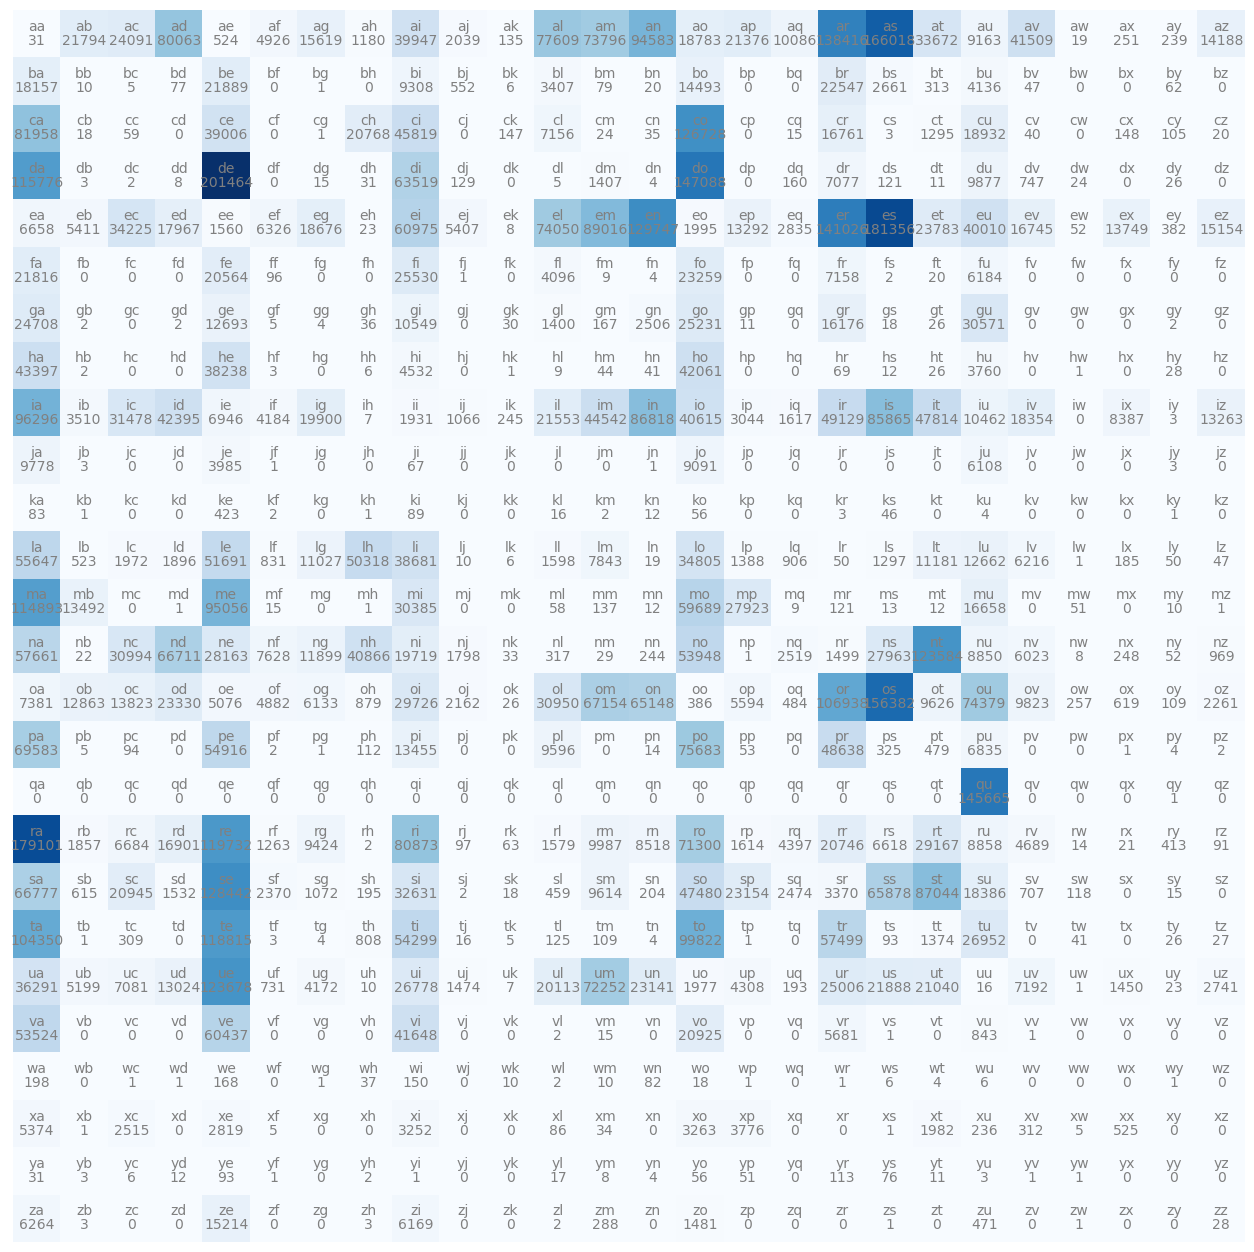

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N[stoi['a']:(stoi['z']+1), stoi['a']:(stoi['z']+1)], cmap='Blues')
for i in range(stoi['a'], stoi['z']+1):
    for j in range(stoi['a'], stoi['z']+1):
        chstr = itos[i] + itos[j]
        plt.text(j-stoi['a'], i-stoi['a'], chstr, ha="center", va="bottom", color='gray')
        plt.text(j-stoi['a'], i-stoi['a'], N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

In [34]:
P = (N+1).float()
P /= P.sum(1, keepdims=True)

In [35]:
g = torch.Generator().manual_seed(0)

for i in range(5):
  
    out = []
    ix = stoi["."]
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == stoi["."]:
            break
    print(''.join(out))
    print()

 leno a ntapra fí aseunão uenfoncesi.

 argos didasa ntuantoguéueliúdítrarerê-lhaidom mo lhe pare nja tá saçãosaizãos.

 coçãosto pl peninúl e que cos de opem ndeivaram forartado polo m ejábe ve pa de jo anenta uado efide alua daino vem uellico apra edo erá óscirem ompana-so es louera asta cilhaz soida, úli.

 qu r, fiade à a odas ndado prdi cobidou pítinta e tose.

 nta.



Bem melhor que antes! Mas isso ainda está longe de ser português... Um problema é que bigramas em si têm pouca informação. Por exemplo, o bigrama "r," pode não ser muito incomum, mas se a palavra começa com " r", é claro que não termina em " r,"

## 1.5 Gerando texto: contando trigramas

Agora, vamos contar todos os trigramas em Machado. Isso vai tomar um pouco mais de tempo --- 10 segundos.

In [36]:
from tqdm import tqdm

In [37]:
t = {}
for char1, char2, char3 in tqdm(zip(text, text[1:], text[2:])):
    trigram = (char1, char2, char3)
    t[trigram] = t.get(trigram, 0) + 1

14460833it [00:05, 2417260.90it/s]


Quais são os trigramas mais e menos frequentes?

In [38]:
sorted(t.items(), key = lambda kv: -kv[1])[0:10]

[((' ', 'd', 'e'), 142121),
 ((' ', 'q', 'u'), 119129),
 (('q', 'u', 'e'), 119043),
 (('d', 'e', ' '), 110280),
 ((' ', 'a', ' '), 98711),
 (('a', 's', ' '), 97777),
 (('o', 's', ' '), 95581),
 ((' ', 'c', 'o'), 95508),
 (('u', 'e', ' '), 94156),
 (('ã', 'o', ' '), 83210)]

In [39]:
sorted(t.items(), key = lambda kv: -kv[1])[-10:]

[(('s', 'y', '?'), 1),
 (('o', 'g', 's'), 1),
 (('o', 'n', 'k'), 1),
 (('n', 'k', 's'), 1),
 (('k', 's', '?'), 1),
 (('s', '.', 'i'), 1),
 (('.', 'i', '.'), 1),
 (('i', '.', 'm'), 1),
 (('r', '-', 'r'), 1),
 (('b', 'r', 'g'), 1)]

Vamos gerar texto amostrando dos trigramas!

In [40]:
M = torch.zeros((vocab_size, vocab_size, vocab_size), dtype=torch.int32)
for trigram in t:
    ix1 = stoi[trigram[0]]
    ix2 = stoi[trigram[1]]
    ix3 = stoi[trigram[2]]
    M[ix1, ix2, ix3] = t[trigram]

In [41]:
Q = (M+1).float()
Q /= Q.sum(2, keepdims=True)

In [42]:
g = torch.Generator().manual_seed(5)

for i in range(5):
  
    out = []
    ix1 = stoi["."]
    ix2 = stoi[" "]
    out.append(itos[ix2])
    
    while True:
        p = Q[ix1, ix2]
        ix3 = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix3])
        if ix3 == stoi["."] or ix3 == stoi["?"]:
            break
        ix1 = ix2
        ix2 = ix3
        
    print(''.join(out))
    print()

 restudestuas e cesentevem ternouvis do de nãs.

 esem compreirecebralisoas dado depaladeitudes sacanhavalhos a na cios, que paravivra que no, suassáscregazigêncomossabérimavossas verguma vamperre inda, filmenhão medo a não mérciandência sum corra, se e ficala, que que geiro cre a novoa ao que conaêéxqúsicasas, a es, asse pode a na.

 lhome acração na há due pidurvo ca e pas daquem ou muinde todo rocava aisupar cernadventite, ger os.

 pos que é, no.

 osse há nadaque sa.



Agora, os piores erros de antes não aparecem mais. Mesmo assim, existe muito mais estrutura em português do que estamos explorando aqui. A gente poderia usar 4, 5, 6-gramas e ainda assim não aprenderíamos tudo o que precisamos, sem contar que o processo todo ficaria muito lento. Tem muito mais estrutura em português do que a gente (acha/imagina/parece).